In [1]:
import pandas as pd
import numpy as np
import glob
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support





Data is present in Epl/data/ and seperate features required are taken to reduce the difficulties in cleaning..empty coloumns if any are filled with NaN.

In [2]:
try:
        data = pd.read_csv("full_feature_dataset_expanded.csv", encoding='utf-8')
except UnicodeDecodeError:
        data = pd.read_csv("full_feature_dataset_expanded.csv", encoding='ISO-8859-1')
print(f"Dataset loaded. Initial shape: {data.shape}")
data = data.drop(columns=['Date'])


Dataset loaded. Initial shape: (9232, 64)


Now that data is ready we have to clean it by checking for duplicates and null values.

In [3]:
print(data.isnull().sum())
print((data.isnull().mean()*100).round(2))

FTR                     0
HomeTeam                0
AwayTeam                0
Avg_Odds_H              0
Avg_Odds_D              0
                       ..
Season                  0
HomeTeam_League_Rank    0
AwayTeam_League_Rank    0
HomeTeam_Strength       0
AwayTeam_Strength       0
Length: 63, dtype: int64
FTR                     0.0
HomeTeam                0.0
AwayTeam                0.0
Avg_Odds_H              0.0
Avg_Odds_D              0.0
                       ... 
Season                  0.0
HomeTeam_League_Rank    0.0
AwayTeam_League_Rank    0.0
HomeTeam_Strength       0.0
AwayTeam_Strength       0.0
Length: 63, dtype: float64


This shows that the dataset has only a very few negligable output there is 1 missing value and that missing value exists in all features so we could drop that row.

In [4]:
data = data.dropna()
print("After dropping missing:",data.shape)
print("Remaining NaN:",data.isnull().sum().sum())

After dropping missing: (9232, 63)
Remaining NaN: 0


In [5]:
duplicates = data.duplicated().sum()
print("Number of duplicated rows:",duplicates)
#data=data.drop(columns=['H_form_FTAG','H_form_FTHG','A_form_FTHG','A_form_FTAG'])

Number of duplicated rows: 0


In [6]:
print(data.columns)
le = LabelEncoder()
data['FTR']=le.fit_transform(data['FTR'])

Index(['FTR', 'HomeTeam', 'AwayTeam', 'Avg_Odds_H', 'Avg_Odds_D', 'Avg_Odds_A',
       'form_goal_diff', 'form_shot_target_diff', 'form_conceded_diff', 'HTHG',
       'HTAG', 'HS', 'AS', 'AST', 'HST', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR',
       'HF', 'AF', 'H_form_FTHG', 'H_form_FTAG', 'H_form_HTHG', 'H_form_HTAG',
       'H_form_HS', 'H_form_AS', 'H_form_HF', 'H_form_AF', 'H_form_HC',
       'H_form_AC', 'H_form_HST', 'H_form_AST', 'H_form_HY', 'H_form_AY',
       'H_form_HR', 'H_form_AR', 'A_form_FTHG', 'A_form_FTAG', 'A_form_HTHG',
       'A_form_HTAG', 'A_form_HS', 'A_form_AS', 'A_form_HF', 'A_form_AF',
       'A_form_HC', 'A_form_AC', 'A_form_HST', 'A_form_AST', 'A_form_HY',
       'A_form_AY', 'A_form_HR', 'A_form_AR', 'H_H2H_win_pct', 'A_H2H_win_pct',
       'H2H_draw_pct', 'Season', 'HomeTeam_League_Rank',
       'AwayTeam_League_Rank', 'HomeTeam_Strength', 'AwayTeam_Strength'],
      dtype='object')


I have done label encoding for all categorical coloumns and the encoder function is also saved in encoders[] to decode for further use

In [7]:
#splitting data into label and feature input

y = data['FTR']

X = data.drop('FTR', axis=1)


In [8]:
print(data.head())

   FTR     HomeTeam    AwayTeam  Avg_Odds_H  Avg_Odds_D  Avg_Odds_A  \
0    2   Sunderland       Derby       1.760       3.325       3.875   
1    0      Everton  Man United       4.315       3.250       1.700   
2    2  Southampton   Newcastle       2.750       3.225       2.225   
3    2      Arsenal    Coventry       1.250       4.415      10.250   
4    2     Charlton   Tottenham       2.685       3.225       2.275   

   form_goal_diff  form_shot_target_diff  form_conceded_diff  HTHG  ...  \
0            -0.4                    0.6                -1.6   1.0  ...   
1            -0.6                   -1.4                 0.6   0.0  ...   
2             0.2                    0.2                 0.8   0.0  ...   
3             1.6                    3.4                -0.6   1.0  ...   
4             1.0                    2.2                 0.4   1.0  ...   

   A_form_HR  A_form_AR  H_H2H_win_pct  A_H2H_win_pct  H2H_draw_pct  \
0        0.2        0.0            0.0            0

In [9]:
print(X.head)


<bound method NDFrame.head of            HomeTeam     AwayTeam  Avg_Odds_H  Avg_Odds_D  Avg_Odds_A  \
0        Sunderland        Derby       1.760       3.325       3.875   
1           Everton   Man United       4.315       3.250       1.700   
2       Southampton    Newcastle       2.750       3.225       2.225   
3           Arsenal     Coventry       1.250       4.415      10.250   
4          Charlton    Tottenham       2.685       3.225       2.275   
...             ...          ...         ...         ...         ...   
9227  Nott'm Forest      Chelsea       3.000       3.750       2.200   
9228    Southampton      Arsenal       8.500       6.000       1.300   
9229      Newcastle      Everton       1.330       5.500       8.500   
9230     Man United  Aston Villa       4.330       4.200       1.700   
9231         Wolves    Brentford       2.700       3.700       2.450   

      form_goal_diff  form_shot_target_diff  form_conceded_diff  HTHG  HTAG  \
0               -0.4      

Splitting Data

In [10]:
from sklearn.model_selection import train_test_split
# Stratified split to preserve class ratios
X_train_cat_split, X_test_cat_split, y_train_cat_split, y_test_cat_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


CATBOOST CLASSIFIER

Fitting with catboost 

In [12]:
# Define which columns are categorical
from catboost import CatBoostClassifier
cat_features = ['HomeTeam', 'AwayTeam','Season']

# Build model
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=7,
    loss_function='MultiClass',
    auto_class_weights='Balanced',
    early_stopping_rounds=50,
    verbose=100
)

# Train model
model.fit(X_train_cat_split, y_train_cat_split, cat_features=cat_features, eval_set=(X_test_cat_split, y_test_cat_split))


0:	learn: 1.0784489	test: 1.0781026	best: 1.0781026 (0)	total: 216ms	remaining: 3m 36s
100:	learn: 0.7539095	test: 0.7976313	best: 0.7976313 (100)	total: 6.62s	remaining: 58.9s
200:	learn: 0.6904998	test: 0.7885074	best: 0.7885074 (200)	total: 12.6s	remaining: 50.2s
300:	learn: 0.6303671	test: 0.7848009	best: 0.7846171 (298)	total: 18.6s	remaining: 43.2s
400:	learn: 0.5782996	test: 0.7852257	best: 0.7834829 (350)	total: 24.9s	remaining: 37.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7834828851
bestIteration = 350

Shrink model to first 351 iterations.


Predicting and accuracy

In [13]:
y_pred = model.predict(X_test_cat_split)

# Accuracy
print("Accuracy:", accuracy_score(y_test_cat_split, y_pred))

# Full classification report
print(classification_report(y_test_cat_split, y_pred))


Accuracy: 0.6534921494315106
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       549
           1       0.40      0.49      0.44       453
           2       0.80      0.70      0.75       845

    accuracy                           0.65      1847
   macro avg       0.64      0.63      0.63      1847
weighted avg       0.68      0.65      0.66      1847



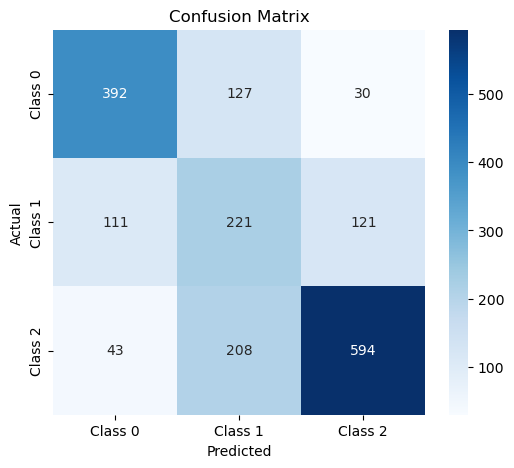

In [14]:
cm = confusion_matrix(y_test_cat_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


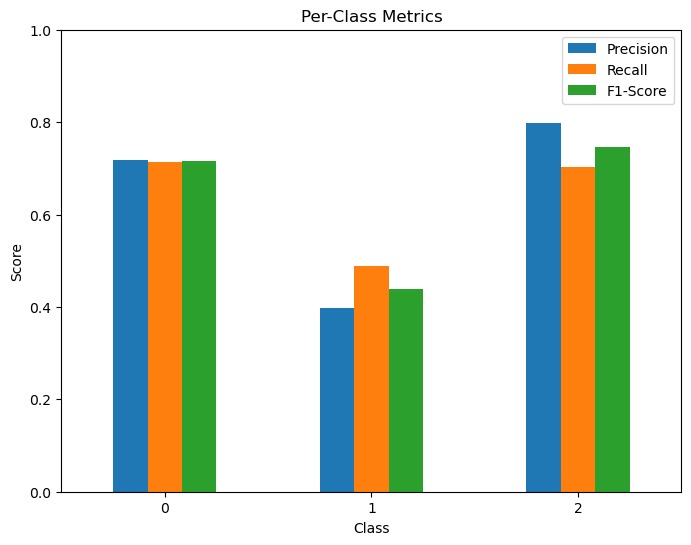

In [15]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_cat_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

In [16]:

categorical_col = data.select_dtypes(include ='object').columns
encoders = {}
for c in categorical_col:
    le = LabelEncoder()
    data[c]=le.fit_transform(data[c])
    encoders[c]=le
print(data.head())

   FTR  HomeTeam  AwayTeam  Avg_Odds_H  Avg_Odds_D  Avg_Odds_A  \
0    2        38        16       1.760       3.325       3.875   
1    0        17        27       4.315       3.250       1.700   
2    2        36        29       2.750       3.225       2.225   
3    2         0        14       1.250       4.415      10.250   
4    2        12        40       2.685       3.225       2.275   

   form_goal_diff  form_shot_target_diff  form_conceded_diff  HTHG  ...  \
0            -0.4                    0.6                -1.6   1.0  ...   
1            -0.6                   -1.4                 0.6   0.0  ...   
2             0.2                    0.2                 0.8   0.0  ...   
3             1.6                    3.4                -0.6   1.0  ...   
4             1.0                    2.2                 0.4   1.0  ...   

   A_form_HR  A_form_AR  H_H2H_win_pct  A_H2H_win_pct  H2H_draw_pct  Season  \
0        0.2        0.0            0.0            0.0           0.0      

Splitting data for xgboost

In [17]:
y = data['FTR']
x = data.drop('FTR',axis=1)

In [18]:
from sklearn.model_selection import train_test_split
# Stratified split to preserve class ratios
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

In [19]:
from imblearn.over_sampling import SMOTE
from collections import Counter



from collections import Counter

# Count samples in training set
counts = Counter(y_train_split)
total = sum(counts.values())

class_weight = {cls: total / (len(counts) * count) for cls, count in counts.items()}
print(class_weight)



counts = Counter(y_train_split)
print("Before SMOTE:", counts)
undetermined_label = 1  
multiplier = 2
target_samples = counts[undetermined_label] * multiplier
sm = SMOTE(sampling_strategy={undetermined_label: target_samples}, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_split, y_train_split)

print("After SMOTE:", Counter(y_train_res))
X_train_res = X_train_res.astype(np.float32)
y_train_res = y_train_res.astype(np.int64)
print(X_train_res.shape)
print(y_train_res.shape)




print("Class distribution after SMOTE:", dict(zip(*np.unique(y_train_res, return_counts=True))))

{0: 1.1230231143552312, 2: 0.7283037475345168, 1: 1.3577863577863578}
Before SMOTE: Counter({2: 3380, 0: 2192, 1: 1813})
After SMOTE: Counter({1: 3626, 2: 3380, 0: 2192})
(9198, 62)
(9198,)
Class distribution after SMOTE: {np.int64(0): np.int64(2192), np.int64(1): np.int64(3626), np.int64(2): np.int64(3380)}


In [20]:

weights = compute_sample_weight(class_weight='balanced', y=y_train_split)
model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    objective='multi:softprob',  
    num_class=3,
    eval_metric='mlogloss',
    random_state = 42
)
param_grid = {
    'n_estimators':[800,1000],
    'max_depth': [4, 5, 6],
    'learning_rate':[0.05,0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_split, y_train_split,sample_weight=weights)
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.8}


In [21]:

from sklearn.metrics import f1_score

# Get predicted probabilities
y_proba = best_model.predict_proba(X_test_split)

# Custom thresholds per class
thresholds = [0.4, 0.6, 0.4]  # start with 0.5 for all classes

def predict_with_thresholds(probs, thresholds):
    preds = []
    for p in probs:
     #Assign class if probability > threshold, else take max
        assigned = [i for i, prob in enumerate(p) if prob >= thresholds[i]]
        if assigned:
            preds.append(assigned[0])
        else:
            preds.append(np.argmax(p))
    return np.array(preds)

y_pred = predict_with_thresholds(y_proba, thresholds)

print("F1 score macro:", f1_score(y_test_split, y_pred, average='macro'))



F1 score macro: 0.6030710366789332


In [22]:

# Accuracy
print("Accuracy:", accuracy_score(y_test_split, y_pred))

# Full classification report
print(classification_report(y_test_split, y_pred))


Accuracy: 0.6475365457498646
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       549
           1       0.39      0.34      0.36       453
           2       0.75      0.78      0.76       845

    accuracy                           0.65      1847
   macro avg       0.60      0.61      0.60      1847
weighted avg       0.64      0.65      0.64      1847



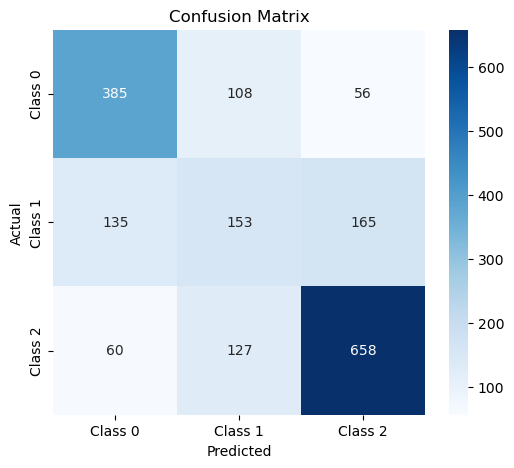

In [23]:
cm = confusion_matrix(y_test_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


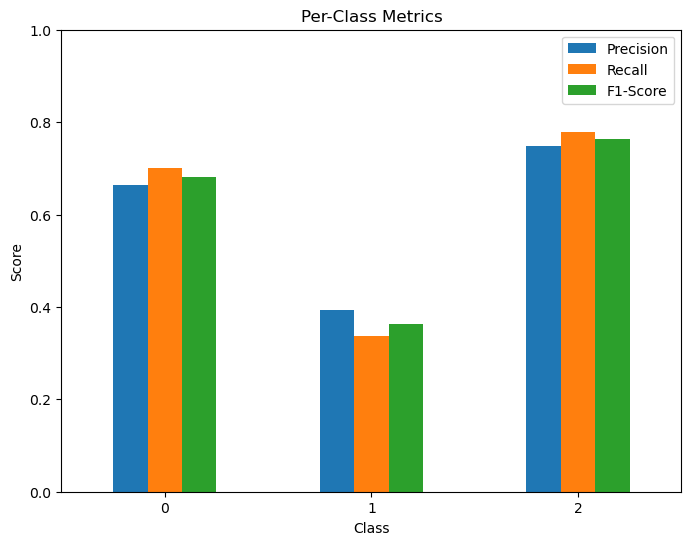

In [24]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

BALANCED RANDOM FOREST CLASSIFIER

In [25]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Define parameter grid
param_dist = {
    "n_estimators": [800,1000,1200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4,5,10],
    "max_features": ['sqrt','log2']
}

# Initialize model
rf = BalancedRandomForestClassifier(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=20,  
    cv=3,       
    scoring="f1_macro",  
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_split, y_train_split)

print("Best Parameters:", random_search.best_params_)
print("Best Score (CV F1):", random_search.best_score_)


Best Parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 10}
Best Score (CV F1): 0.600943191638092


In [26]:
best_rf = random_search.best_estimator_

y_proba = best_rf.predict_proba(X_test_split)
y_pred = np.argmax(y_proba, axis=1) 


In [27]:
# Accuracy
print("Accuracy:", accuracy_score(y_test_split, y_pred))

# Full classification report
print(classification_report(y_test_split, y_pred))

Accuracy: 0.634001082837033
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       549
           1       0.37      0.38      0.38       453
           2       0.76      0.73      0.74       845

    accuracy                           0.63      1847
   macro avg       0.60      0.60      0.60      1847
weighted avg       0.64      0.63      0.63      1847



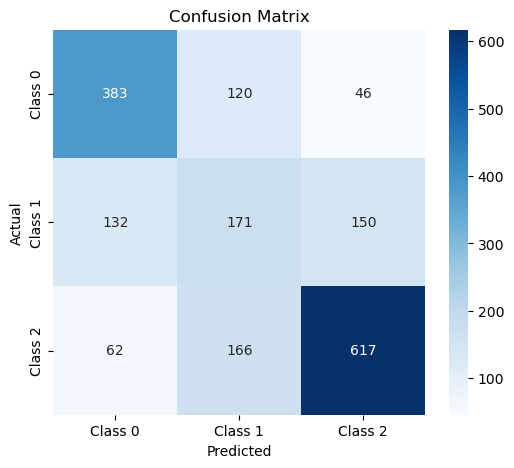

In [28]:
cm = confusion_matrix(y_test_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


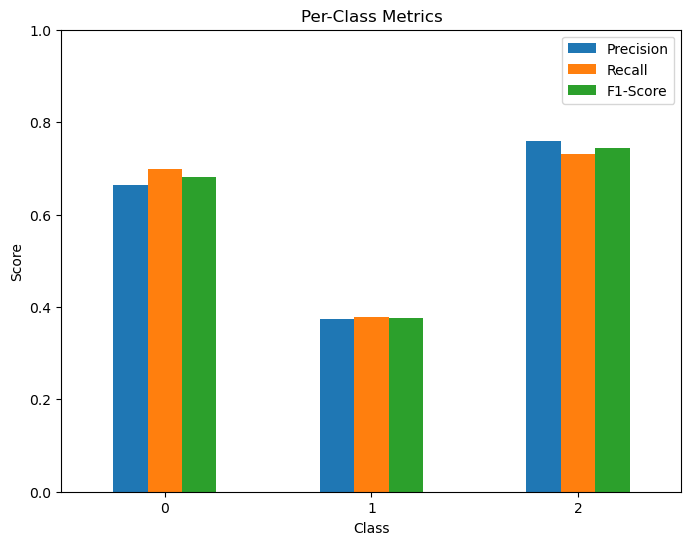

In [29]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

RANDOM FOREST CLASSIFIER

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Define parameter grid
param_dist = {
    "n_estimators": [800,1000,1200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4,5,10],
    "max_features": ['sqrt','log2'],
    "bootstrap": [True, False]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=20,  # number of random combinations
    cv=3,       # 3-fold cross validation
    scoring="f1_macro",  # you can also try "accuracy"
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_res, y_train_res)

print("Best Parameters:", random_search.best_params_)
print("Best Score (CV F1):", random_search.best_score_)

Best Parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best Score (CV F1): 0.6815639191768191


In [31]:
best_rf = random_search.best_estimator_

y_proba = best_rf.predict_proba(X_test_split)
y_pred = np.argmax(y_proba, axis=1) 


In [32]:
# Accuracy
print("Accuracy:", accuracy_score(y_test_split, y_pred))

# Full classification report
print(classification_report(y_test_split, y_pred))

Accuracy: 0.6513264753654575
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       549
           1       0.41      0.31      0.35       453
           2       0.70      0.83      0.76       845

    accuracy                           0.65      1847
   macro avg       0.61      0.60      0.60      1847
weighted avg       0.64      0.65      0.64      1847



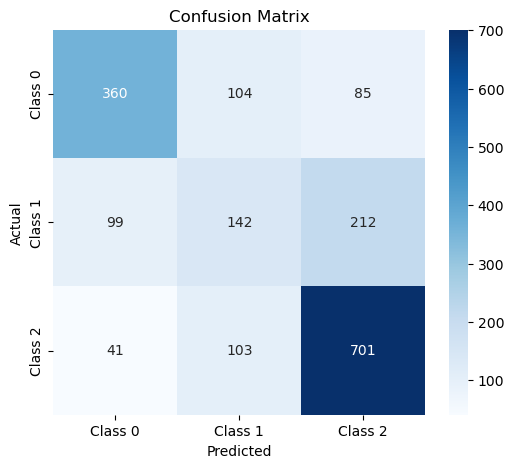

In [33]:
cm = confusion_matrix(y_test_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


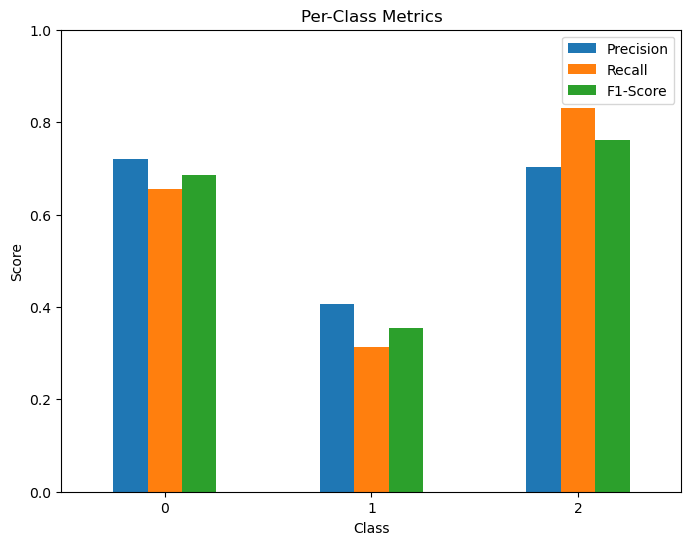

In [34]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

In [35]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Base classifier options
base_estimators = [
    DecisionTreeClassifier(max_depth=1),
    DecisionTreeClassifier(max_depth=2),
    DecisionTreeClassifier(max_depth=3)
]

# Parameter grid
param_dist = {
    "n_estimators": [10, 20, 30],
    "estimator": base_estimators
}

# Initialize EasyEnsemble
eec = EasyEnsembleClassifier(random_state=42, n_jobs=-1)

# Randomized search
rs = RandomizedSearchCV(
    estimator=eec,
    param_distributions=param_dist,
    n_iter=10,        # number of random combinations
    cv=3,             # 3-fold cross-validation
    scoring="f1_macro",  # optimize macro F1 (balances all classes)
    n_jobs=-1,
    random_state=42
)

# Fit on original imbalanced data (EEC handles balancing internally)
rs.fit(X_train_split, y_train_split)

# Best parameters
print("Best Parameters:", rs.best_params_)
print("Best CV F1 (macro):", rs.best_score_)

# Evaluate on test set
y_pred = rs.predict(X_test_split)
print(classification_report(y_test_split, y_pred))


c:\Users\arnas\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'n_estimators': 20, 'estimator': DecisionTreeClassifier(max_depth=3)}
Best CV F1 (macro): 0.5776242285984196
              precision    recall  f1-score   support

           0       0.64      0.70      0.66       549
           1       0.35      0.43      0.39       453
           2       0.77      0.63      0.70       845

    accuracy                           0.60      1847
   macro avg       0.59      0.59      0.58      1847
weighted avg       0.63      0.60      0.61      1847



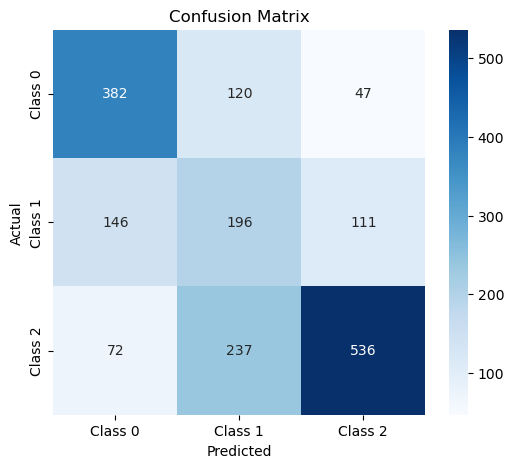

In [36]:
cm = confusion_matrix(y_test_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


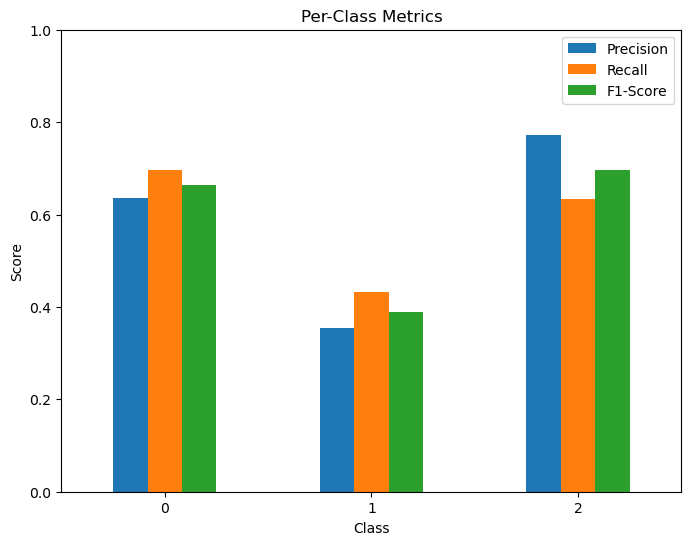

In [37]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()